# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `6_svd_swe_new_normalized.ipynb` 
### Normalizing the svd by the same method as the deltaDCE anaylsis 

* this notebook is copied from `6_svd_swe.ipynb` and is being adapted to reflect the normalization method from `11_delta_dce_categories.ipynb`

**Env**: I was using env `rasterio`, and everything was good except the scalebar addition Steven beautifully created.\
So, now I made a copy of `rasterio` called `rasterio_scalebar` which I then pip installed `matplotlib-scalebar`\
That seems to work, so let's proceed...

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
# from matplotlib_scalebar.scalebar import ScaleBar

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import rioxarray
import rasterio
# import rasterstats
import scipy

# import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

c:\Users\Lumbr\miniconda3\envs\rasterio_scalebar\lib\site-packages\pyproj\__init__.py:73: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [3]:
# !pip install matplotlib-scalebar

In [2]:
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
# ds = xr.open_dataset('~/RAPID/cer_treatment_region_dataset_all_variables/cer_treatment_region_dataset_all_variables.nc') # Steven's path
ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') 

---

In [4]:
ds

<xarray.Dataset>
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 2.111e+05 ... 2.097e+05
  * band                              (band) int32 1
    spatial_ref                       int32 ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 ...
    dce_rapid                         (band, y, x) float32 ...
    giulia_dce_rapid                  (band, y, x) float32 ...
    giulia_dce_ncalm                  (band, y, x) float32 ...
    slope                             (band, y, x) float32 ...
    aspect                            (band, y, x) float32 ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 ...

In [15]:
# Constants 
# define path to save the figures to
figure_path = "C:\\Users\\Lumbr\\OneDrive - UW\\Documents - mountainhydro\\People\\CassieLumbrazo\\EasternCascades\\Writing\\5_Manuscript\\2_PostDefense\\python_figures\\"

# colors
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

colorcontrol = 'black'
colortreatment = 'saddlebrown'

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

In [9]:
# from scipy.stats.mstats import mquantiles

# def cdf(x):
#     x = x[~np.isnan(x)]
#     q = np.arange(0,1,0.01)
#     y = mquantiles(x, q)
#     return (y, q)

### Add Code from `11_delta_dce_categories.ipynb` to normalize snow depth the same way

In [10]:
# Calculate delta DCE
delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# Create a new variable to store the categories
# Category 1: Most Forested (ncalm negative, rapid negative, delta DCE negative) forest to denser forest
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 1, 0)

# Category 2: More Forested (ncalm negative, rapid negative, delta DCE positive) forest to edge 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 2, ds['delta_dce_cat'])

# Category 3: No Change (delta DCE close to zero (absolute value less than 0.5)) no change 
ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

# Category 4: Less Open (ncalm positive, rapid less than ncalm) open to less open 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] < ds['dce_ncalm']), 4, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce < 0), 4, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 5: More Open (ncalm positive, rapid greater than ncalm) open to more open 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] > ds['dce_ncalm']), 5, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce > 0), 5, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 6: Most Open (ncalm negative, rapid positive) forest to open 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] > 0), 6, ds['delta_dce_cat'])

In [11]:
# Calculate mean and standard deviation of snow depth for delta DCE category 3 (no change)
mean_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).mean()
std_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).std()

mean_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).mean()
std_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).std()

# Normalize snow depth for each year
ds['hs_ncalm_normalized'] = (ds['hs_ncalm'] - mean_2021) / std_2021
ds['hs_rapid_normalized'] = (ds['hs_rapid'] - mean_2023) / std_2023

# Calculate the difference in normalized snow depth 
ds['hs_diff_normalized'] = ds['hs_rapid_normalized'] - ds['hs_ncalm_normalized']

# Print the means and stds 
print('ΔDCE Category 3 Mean 2021:', mean_2021.values.round(3))
print('ΔDCE Category 3 Mean 2023:', mean_2023.values.round(3))
print('ΔDCE Category 3 Std 2021:', std_2021.values.round(3))
print('ΔDCE Category 3 Std 2023:', std_2023.values.round(3))

ΔDCE Category 3 Mean 2021: 0.167
ΔDCE Category 3 Mean 2023: 0.198
ΔDCE Category 3 Std 2021: 0.225
ΔDCE Category 3 Std 2023: 0.235


Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [12]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [ ]:
#.where(np.isnan(ds.baf))
#.where(np.isnan(ds.baf))

# Previous Code below, 
ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

Now, do the same calculation for the new normalized method (same as deltaDCE)

In [37]:
# Now, redo that code but with the new normalized snow depth values from delta DCE 
ds['sdv_rapid_new_norm'] = (ds['hs_rapid_zeros_removed'] - mean_2023) / std_2023 # those mean and std are calculated above with detla DCE
ds['sdv_ncalm_new_norm'] = (ds['hs_ncalm_zeros_removed'] - mean_2021) / std_2021 # those mean and std are calculated above with delta DCE

ds['diff_sdv_rapid_ncalm_new_norm'] = (ds['sdv_rapid_new_norm'] - ds['sdv_ncalm_new_norm']) # 2023 SDV - 2021 SDV

## Plots

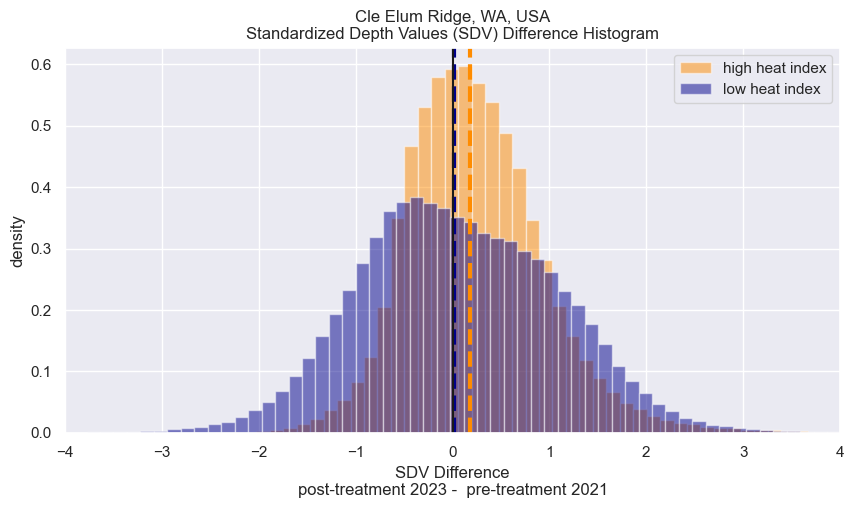

In [18]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm'].where(ds['dah_binary'] ==  1).plot.hist(bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm'].where(ds['dah_binary'] == -1).plot.hist(bins=100, color=colornorth, alpha=0.5, density=True, label='low heat index');

# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm'].where(ds['dah_binary'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
plt.axvline(ds['diff_sdv_rapid_ncalm'].where(ds['dah_binary'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-4,4);
plt.ylabel('density')
plt.xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')

plt.title('Cle Elum Ridge, WA, USA\nStandardized Depth Values (SDV) Difference Histogram')
plt.show()

The same plot with the "new_norm" version...

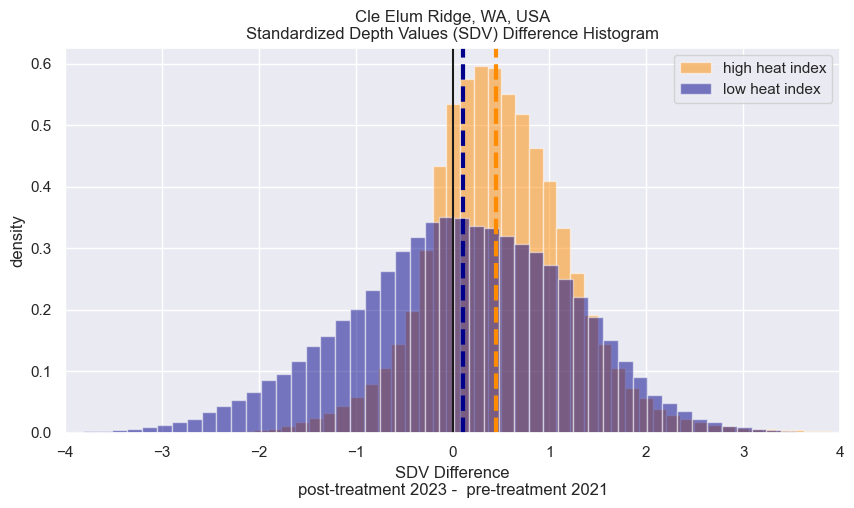

In [19]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['dah_binary'] ==  1).plot.hist(bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['dah_binary'] == -1).plot.hist(bins=100, color=colornorth, alpha=0.5, density=True, label='low heat index');

# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['dah_binary'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
plt.axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['dah_binary'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-4,4);
plt.ylabel('density')
plt.xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')

plt.title('Cle Elum Ridge, WA, USA\nStandardized Depth Values (SDV) Difference Histogram')
plt.show()

North vs South, instead of heat index

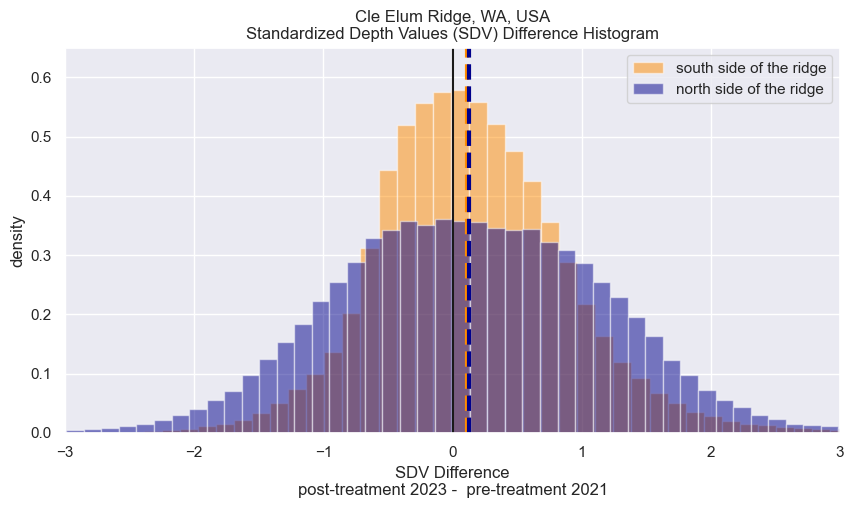

In [15]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).plot.hist(bins=100, color=colorsouth, alpha=0.5, density=True, label='south side of the ridge');
ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).plot.hist(bins=100, color=colornorth, alpha=0.5, density=True, label='north side of the ridge');

# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
plt.axvline(ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

# plt.xlim(-4,4);
# plt.xlim(-3.2,3.2);
plt.xlim(-3,3);

plt.ylim(0,0.65)
plt.ylabel('density')
plt.xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')

plt.title('Cle Elum Ridge, WA, USA\nStandardized Depth Values (SDV) Difference Histogram')

# export the figure with high resolution
figure_name = 'diff_SDV_side_of_ridge.png'
plt.savefig(figure_path + figure_name, dpi=500)

And the same with the new normalized values 

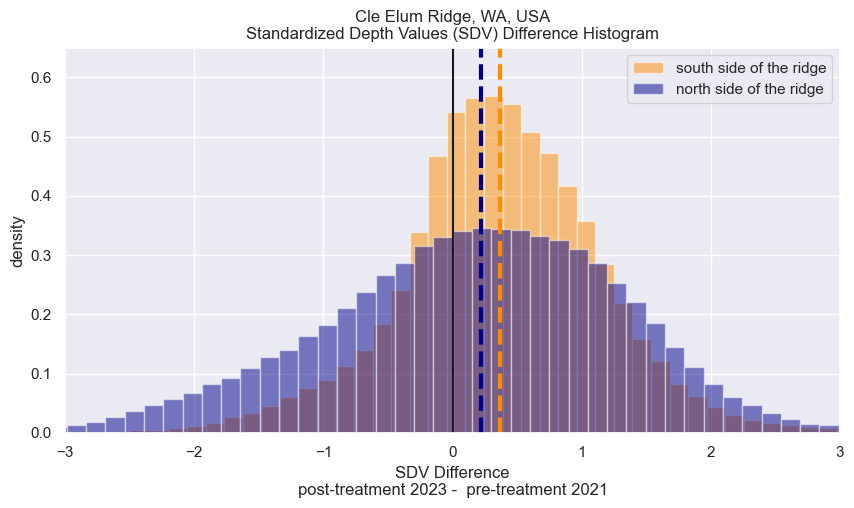

In [20]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).plot.hist(bins=100, color=colorsouth, alpha=0.5, density=True, label='south side of the ridge');
ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).plot.hist(bins=100, color=colornorth, alpha=0.5, density=True, label='north side of the ridge');

# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
plt.axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

# plt.xlim(-4,4);
# plt.xlim(-3.2,3.2);
plt.xlim(-3,3);

plt.ylim(0,0.65)
plt.ylabel('density')
plt.xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')

plt.title('Cle Elum Ridge, WA, USA\nStandardized Depth Values (SDV) Difference Histogram')

# export the figure with high resolution
figure_name = 'diff_SDV_side_of_ridge.png'
plt.savefig(figure_path + figure_name, dpi=500)

Just wanted to double check that I am indeed plotting the north side and south sides correctly...

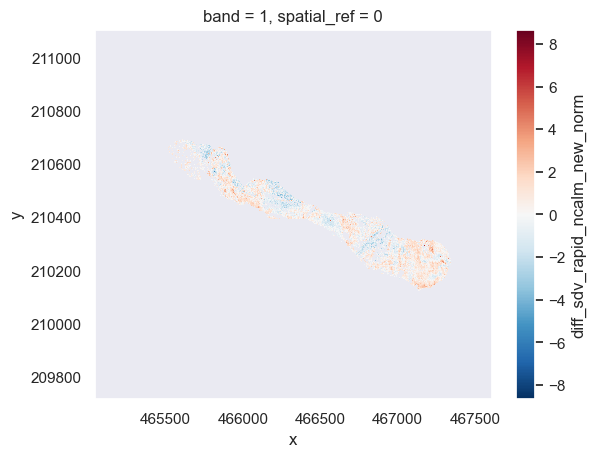

In [39]:
ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  -1).plot()

Now, just look at treatment and control across the ridge, 

In [21]:
ds['sdv_diff_treatment'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf))
ds['sdv_diff_control']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf))

ds['sdv_diff_treatment_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf))
ds['sdv_diff_control_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf))

In [22]:
# colorcontrol = 'dimgray'
colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'
colortreatment2 = 'darkslategrey'

Untreated vs treated areas...

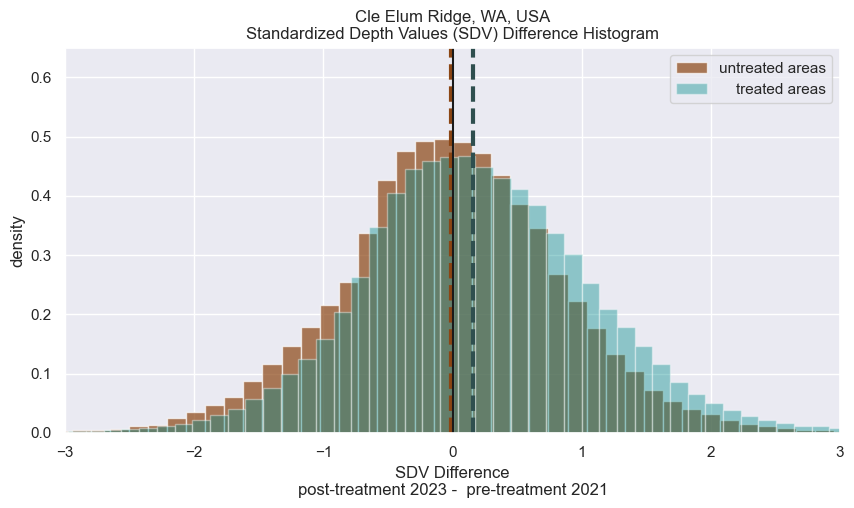

In [23]:
fig = plt.figure(figsize=(10,5))
ds['sdv_diff_control'].plot.hist(bins=100, color=colorcontrol, alpha=0.7, density=True, label='untreated areas');
ds['sdv_diff_treatment'].plot.hist(bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
plt.axvline(ds['sdv_diff_control'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
plt.axvline(ds['sdv_diff_treatment'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');

plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-3,3);
plt.ylim(0,0.65)
plt.ylabel('density')
plt.xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')

plt.title('Cle Elum Ridge, WA, USA\nStandardized Depth Values (SDV) Difference Histogram')


# export the figure with high resolution
figure_name = 'diff_SDV_treatment_control.png'
plt.savefig(figure_path + figure_name, dpi=500)

And, with the new normalization 

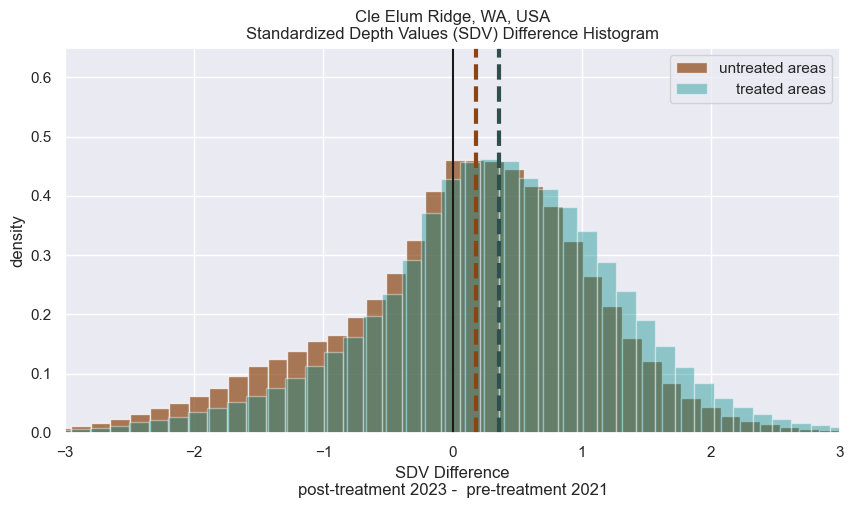

In [24]:
fig = plt.figure(figsize=(10,5))
ds['sdv_diff_control_new_norm'].plot.hist(bins=100, color=colorcontrol, alpha=0.7, density=True, label='untreated areas');
ds['sdv_diff_treatment_new_norm'].plot.hist(bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
plt.axvline(ds['sdv_diff_control_new_norm'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
plt.axvline(ds['sdv_diff_treatment_new_norm'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');

plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-3,3);
plt.ylim(0,0.65)
plt.ylabel('density')
plt.xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')

plt.title('Cle Elum Ridge, WA, USA\nStandardized Depth Values (SDV) Difference Histogram')


# export the figure with high resolution
figure_name = 'diff_SDV_treatment_control.png'
plt.savefig(figure_path + figure_name, dpi=500)

In [20]:
# print the medians from the plot 
print(f'median treatment: ', ds['sdv_diff_treatment'].median().values)
print(f'median control: ', ds['sdv_diff_control'].median().values)

median treatment:  0.1569359302520752
median control:  -0.014008000493049622


In [36]:
# print the medians from the plot 
print(f'median treatment: ', ds['sdv_diff_treatment_new_norm'].median().values)
print(f'median control: ', ds['sdv_diff_control_new_norm'].median().values)

median treatment:  0.3599283261680798
median control:  0.18281201979557604


Now, north and south by treated and untreated areas

In [26]:
ds['sdv_diff_treatment_south'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

In [27]:
ds['sdv_diff_treatment_south_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

By each side of the ridge, with the treated and untreated areas

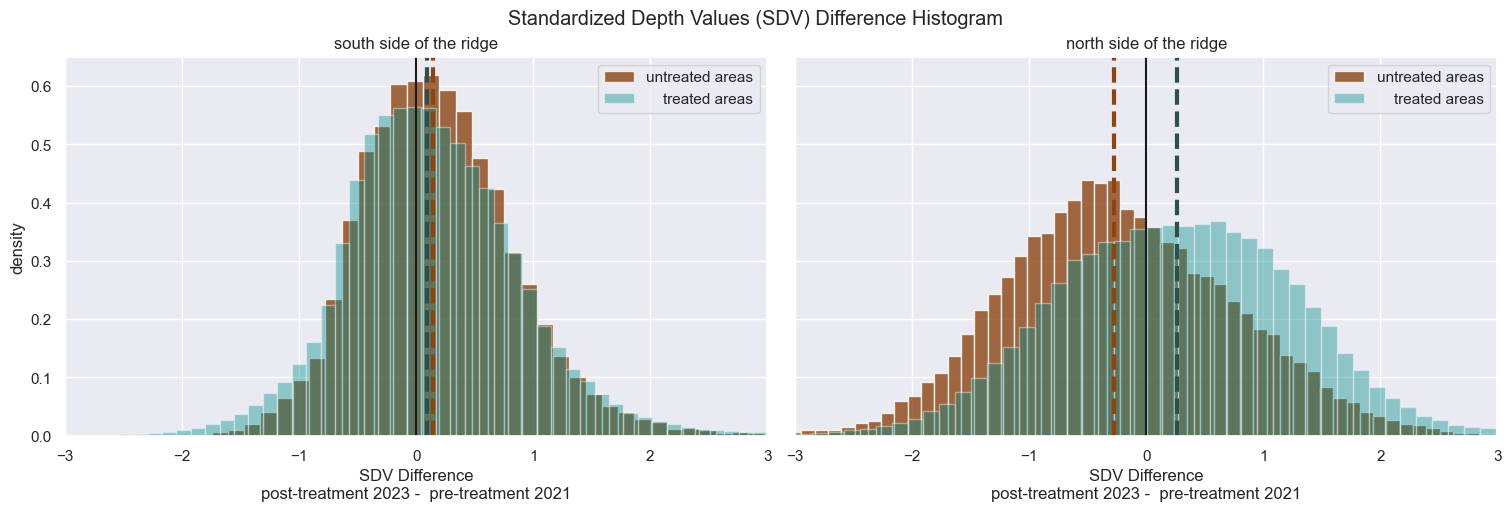

In [28]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5), constrained_layout = True)
ds['sdv_diff_control_south'].plot.hist(ax=axes[0], bins=100, color=colorcontrol, alpha=0.8, density=True, label='untreated areas');
ds['sdv_diff_treatment_south'].plot.hist(ax=axes[0], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');
ds['sdv_diff_control_north'].plot.hist(ax=axes[1], bins=100, color=colorcontrol, alpha=0.8, density=True, label='untreated areas');
ds['sdv_diff_treatment_north'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['sdv_diff_control_south'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['sdv_diff_treatment_south'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_control_north'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_treatment_north'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
axes[0].legend()
axes[1].legend()

axes[0].set_ylim(0,0.65);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density')
axes[0].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')

plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')
axes[0].set_title('south side of the ridge')
axes[1].set_title('north side of the ridge')

plt.show()

And, with the new normalized values

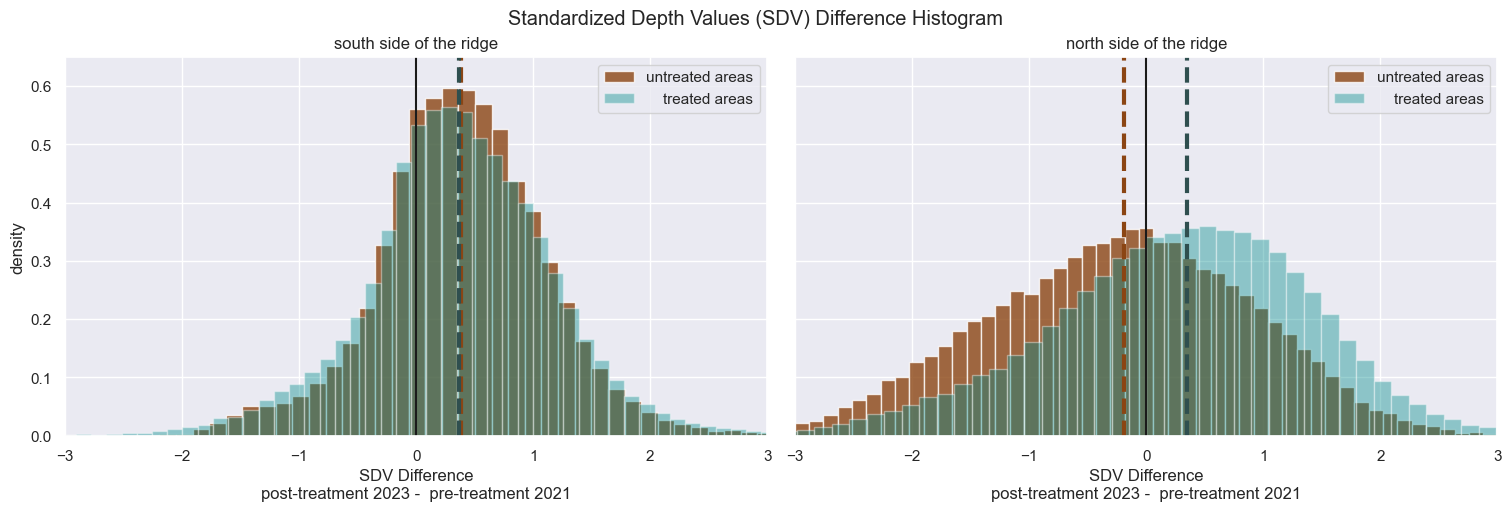

In [29]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5), constrained_layout = True)
ds['sdv_diff_control_south_new_norm'].plot.hist(ax=axes[0], bins=100, color=colorcontrol, alpha=0.8, density=True, label='untreated areas');
ds['sdv_diff_treatment_south_new_norm'].plot.hist(ax=axes[0], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');
ds['sdv_diff_control_north_new_norm'].plot.hist(ax=axes[1], bins=100, color=colorcontrol, alpha=0.8, density=True, label='untreated areas');
ds['sdv_diff_treatment_north_new_norm'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['sdv_diff_control_south_new_norm'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['sdv_diff_treatment_south_new_norm'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_control_north_new_norm'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_treatment_north_new_norm'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
axes[0].legend()
axes[1].legend()

axes[0].set_ylim(0,0.65);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density')
axes[0].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021')

plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')
axes[0].set_title('south side of the ridge')
axes[1].set_title('north side of the ridge')

plt.show()

In [23]:
# print the medians 
print(f'median control south: ', ds['sdv_diff_control_south'].median().values)
print(f'median treatment south: ', ds['sdv_diff_treatment_south'].median().values)
print(f'median control north: ', ds['sdv_diff_control_north'].median().values)
print(f'median treatment north: ', ds['sdv_diff_treatment_north'].median().values)

median control south:  0.14517933130264282
median treatment south:  0.09666246175765991
median control north:  -0.27967047691345215
median treatment north:  0.26279735565185547


In [30]:
# print the medians 
print(f'median control south: ', ds['sdv_diff_control_south_new_norm'].median().values)
print(f'median treatment south: ', ds['sdv_diff_treatment_south_new_norm'].median().values)
print(f'median control north: ', ds['sdv_diff_control_north_new_norm'].median().values)
print(f'median treatment north: ', ds['sdv_diff_treatment_north_new_norm'].median().values)

median control south:  0.3872036322744788
median treatment south:  0.3648970397448372
median control north:  -0.19351375056773093
median treatment north:  0.35076952513755666


## One part of the figure...

With the previous values,

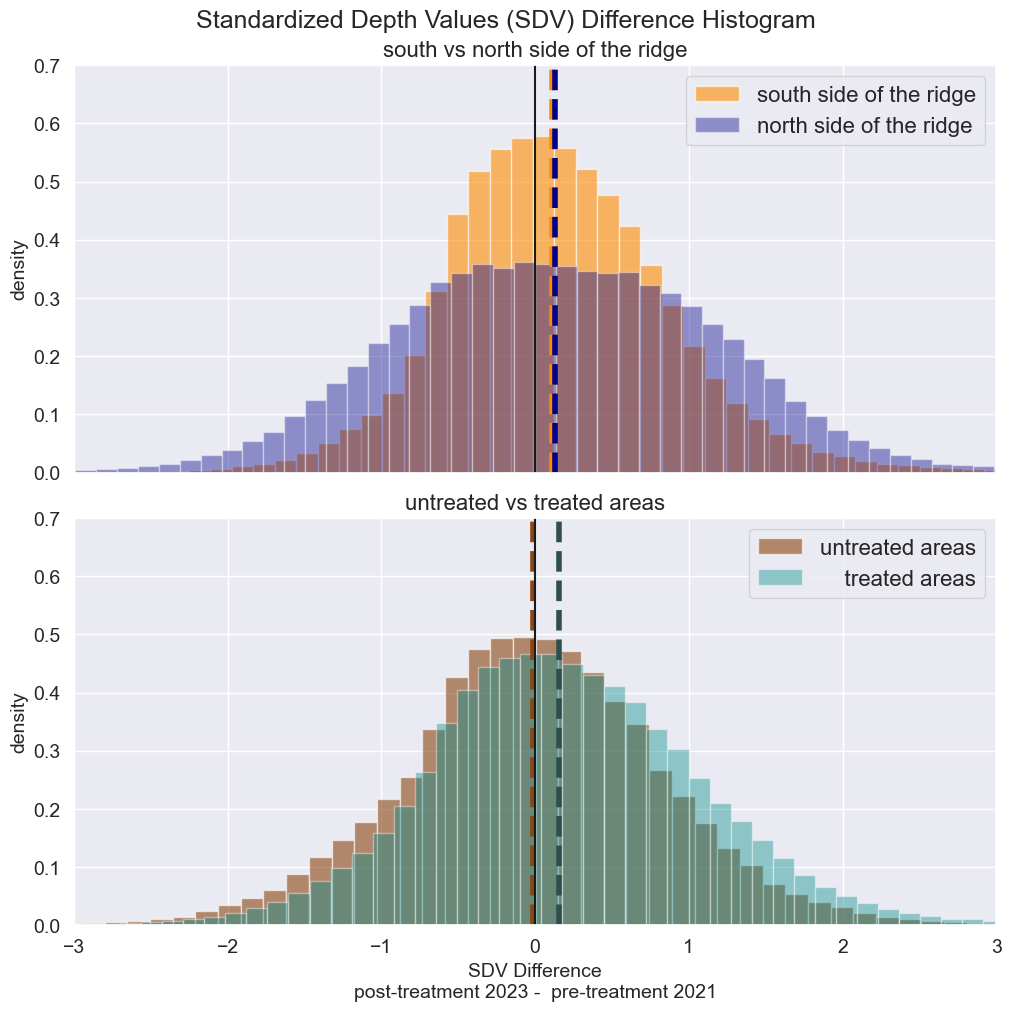

In [24]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)

ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).plot.hist(ax=axes[0], bins=100, color=colorsouth, alpha=0.6, density=True, label='south side of the ridge');
ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).plot.hist(ax=axes[0], bins=100, color=colornorth, alpha=0.4, density=True, label='north side of the ridge');
ds['sdv_diff_control'].plot.hist(  ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=4, label='');
axes[0].axvline(ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_control'].median(), color=colorcontrol, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_treatment'].median(), color=colortreatment2, linestyle='dashed', linewidth=4, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 16)
axes[1].legend(fontsize = 16)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 14)
axes[1].set_ylabel('density', fontsize = 14)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021', fontsize=14)

plt.suptitle('Standardized Depth Values (SDV) Difference Histogram', fontsize=18)

axes[0].set_title('south vs north side of the ridge', fontsize = 16)
axes[1].set_title('untreated vs treated areas', fontsize = 16)

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)

# export the figure with high resolution
figure_name = 'FigureSVD_left.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

And the same with the new normalization, 

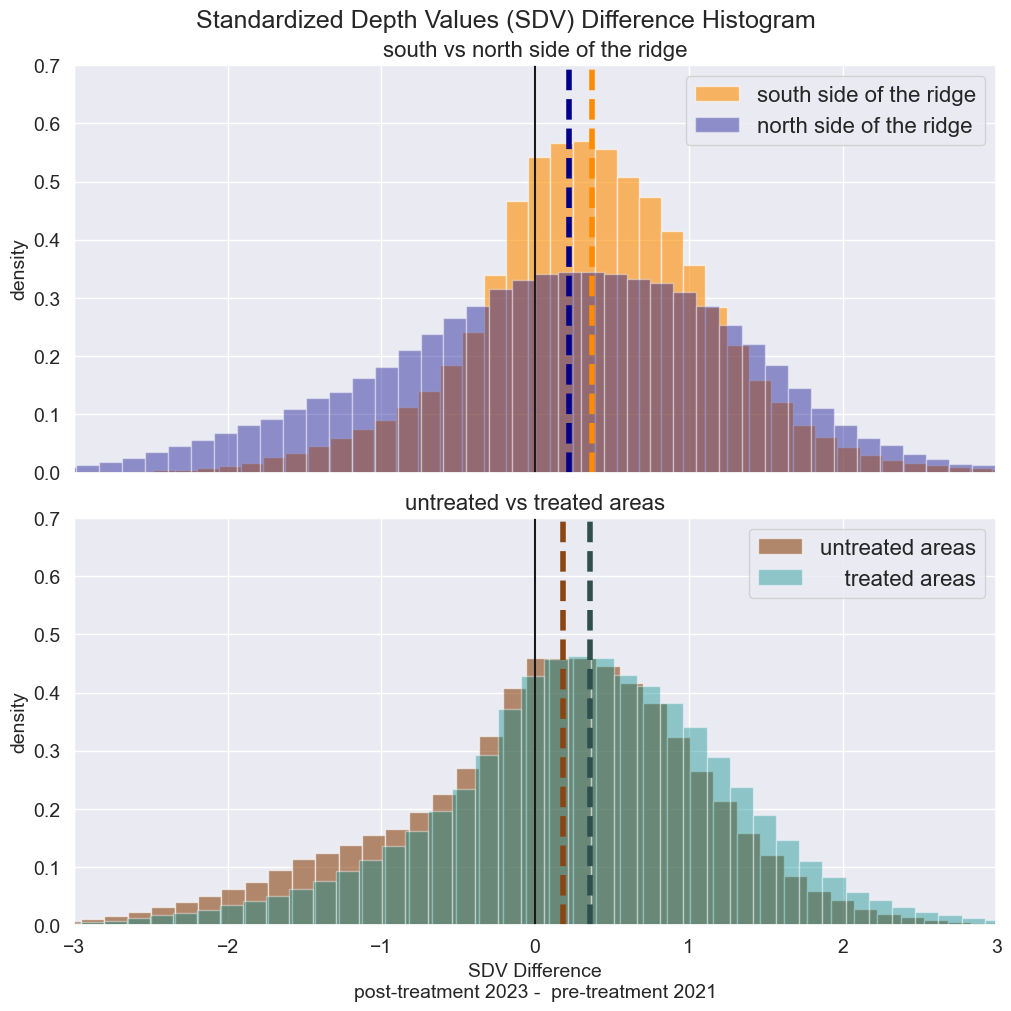

In [35]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)

ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).plot.hist(ax=axes[0], bins=100, color=colorsouth, alpha=0.6, density=True, label='south side of the ridge');
ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).plot.hist(ax=axes[0], bins=100, color=colornorth, alpha=0.4, density=True, label='north side of the ridge');
ds['sdv_diff_control_new_norm'].plot.hist(  ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_new_norm'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=4, label='');
axes[0].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_control_new_norm'].median(), color=colorcontrol, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_treatment_new_norm'].median(), color=colortreatment2, linestyle='dashed', linewidth=4, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 16)
axes[1].legend(fontsize = 16)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 14)
axes[1].set_ylabel('density', fontsize = 14)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021', fontsize=14)

plt.suptitle('Standardized Depth Values (SDV) Difference Histogram', fontsize=18)

axes[0].set_title('south vs north side of the ridge', fontsize = 16)
axes[1].set_title('untreated vs treated areas', fontsize = 16)

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)

# export the figure with high resolution
figure_name = 'FigureSVD_left.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

### And the second part of the figure 

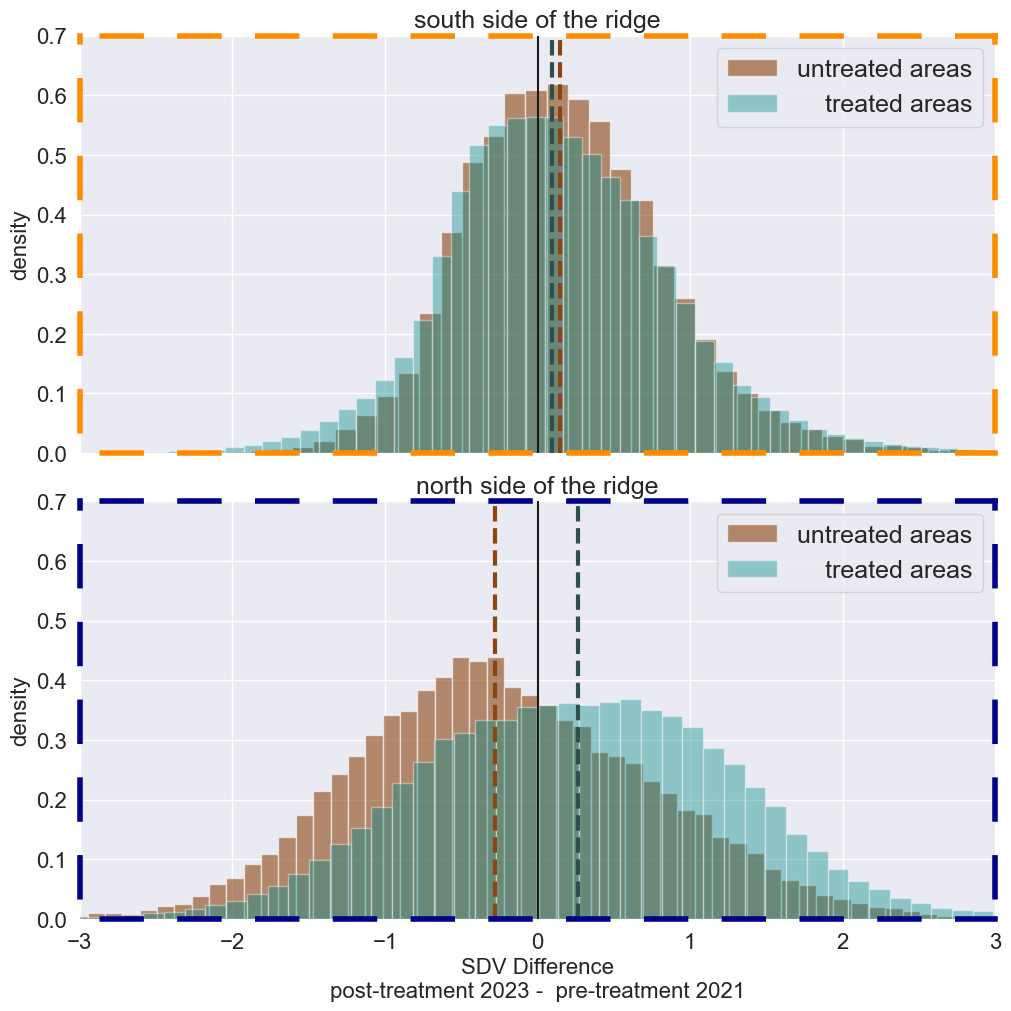

In [32]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)
ds['sdv_diff_control_south'].plot.hist(ax=axes[0], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_south'].plot.hist(ax=axes[0], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');
ds['sdv_diff_control_north'].plot.hist(ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_north'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['sdv_diff_control_south'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['sdv_diff_treatment_south'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_control_north'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_treatment_north'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 18)
axes[1].legend(fontsize = 18)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 16)
axes[1].set_ylabel('density', fontsize = 16)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021', fontsize=16)

# plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')

axes[0].set_title('south side of the ridge', fontsize = 18)
axes[1].set_title('north side of the ridge', fontsize = 18)

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)

# make an orange outline on the first subplot 
for spine in axes[0].spines.values():
    spine.set_edgecolor(colorsouth)
    spine.set_linewidth(4)
    # spine.set_linestyle('dashed')
    spine.set_linestyle((10, (7,7))) # line width, then (points, gap)
    
# make a blue outline on the second subplot
for spine in axes[1].spines.values():
    spine.set_edgecolor(colornorth)
    spine.set_linewidth(4)
    spine.set_linestyle((10, (7,7)))
    
# # add a C) and D) to the subplots 
# axes[0].text(0.01, 0.9, 'C)', fontsize=18, transform=axes[0].transAxes)
# axes[1].text(0.01, 0.9, 'D)', fontsize=18, transform=axes[1].transAxes)

# export the figure with high resolution
figure_name = 'FigureSVD_right.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

And, with the new normalized values

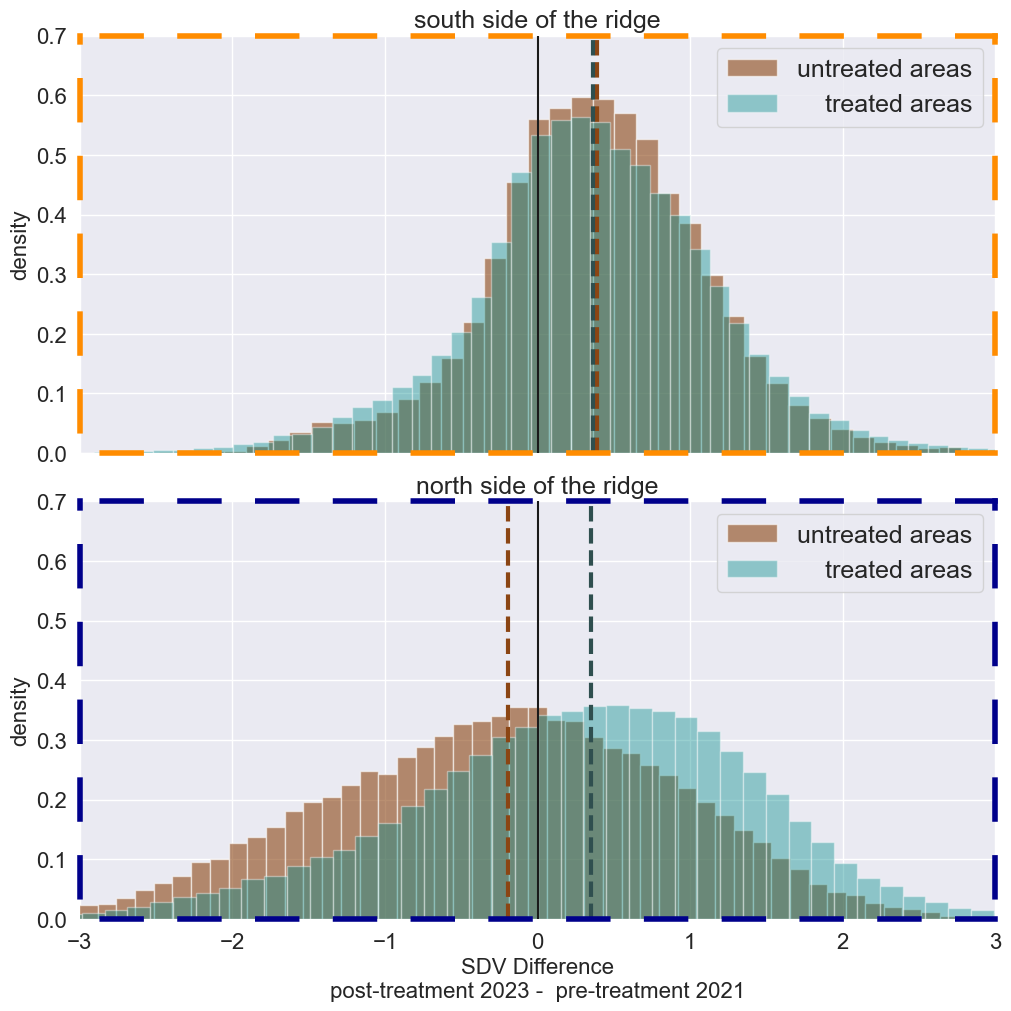

In [33]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)
ds['sdv_diff_control_south_new_norm'].plot.hist(ax=axes[0], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_south_new_norm'].plot.hist(ax=axes[0], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');
ds['sdv_diff_control_north_new_norm'].plot.hist(ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_north_new_norm'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['sdv_diff_control_south_new_norm'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['sdv_diff_treatment_south_new_norm'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_control_north_new_norm'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_treatment_north_new_norm'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 18)
axes[1].legend(fontsize = 18)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 16)
axes[1].set_ylabel('density', fontsize = 16)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 -  pre-treatment 2021', fontsize=16)

# plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')

axes[0].set_title('south side of the ridge', fontsize = 18)
axes[1].set_title('north side of the ridge', fontsize = 18)

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)

# make an orange outline on the first subplot 
for spine in axes[0].spines.values():
    spine.set_edgecolor(colorsouth)
    spine.set_linewidth(4)
    # spine.set_linestyle('dashed')
    spine.set_linestyle((10, (7,7))) # line width, then (points, gap)
    
# make a blue outline on the second subplot
for spine in axes[1].spines.values():
    spine.set_edgecolor(colornorth)
    spine.set_linewidth(4)
    spine.set_linestyle((10, (7,7)))
    
# # add a C) and D) to the subplots 
# axes[0].text(0.01, 0.9, 'C)', fontsize=18, transform=axes[0].transAxes)
# axes[1].text(0.01, 0.9, 'D)', fontsize=18, transform=axes[1].transAxes)

# export the figure with high resolution
figure_name = 'FigureSVD_right.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

Now, north and south with small heat index differences too

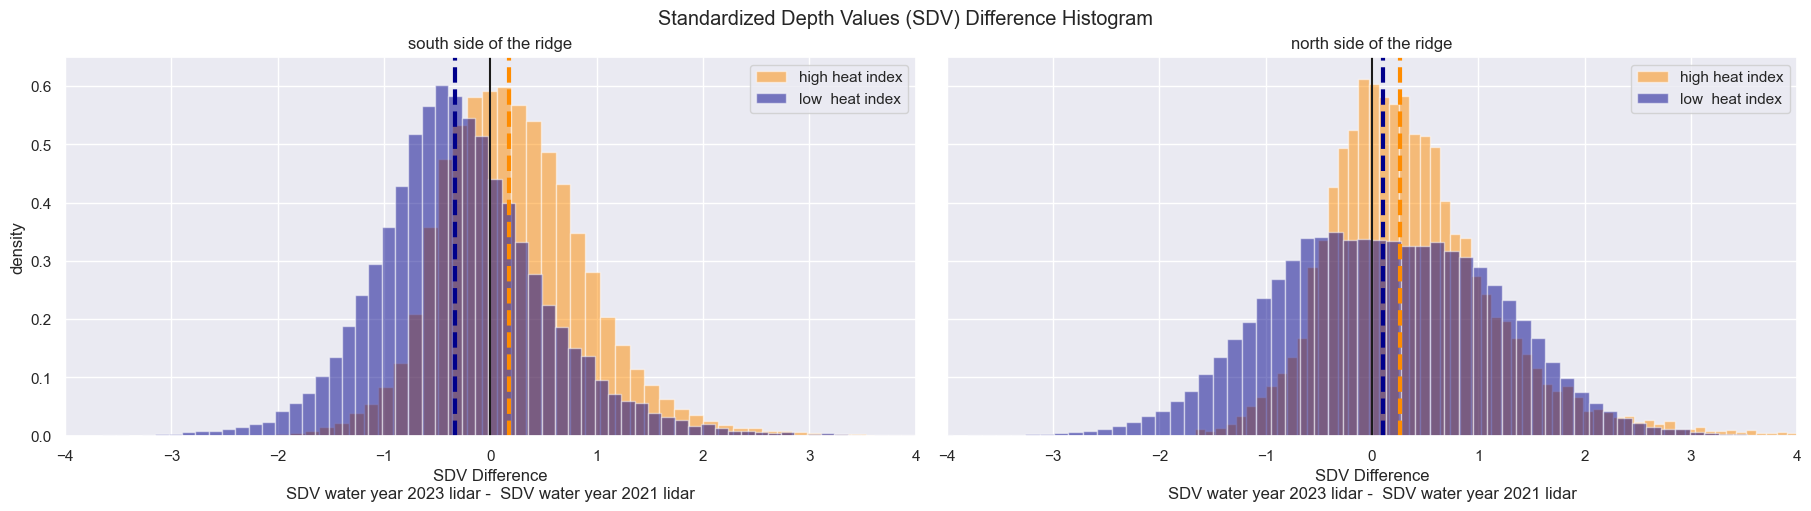

In [29]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,5), constrained_layout = True)
ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] ==  1)).plot.hist(ax=axes[0], bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] == -1)).plot.hist(ax=axes[0], bins=100, color=colornorth, alpha=0.5, density=True, label='low  heat index');
ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] ==  1)).plot.hist(ax=axes[1], bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] == -1)).plot.hist(ax=axes[1], bins=100, color=colornorth, alpha=0.5, density=True, label='low  heat index');

# plot the median line 
axes[0].axvline(ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] ==  1)).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] == -1)).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] ==  1)).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] == -1)).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend()
axes[1].legend()

axes[0].set_ylim(0,0.65);
axes[0].set_xlim(-4,4);
axes[0].set_ylabel('density')
axes[0].set_xlabel('SDV Difference\nSDV water year 2023 lidar -  SDV water year 2021 lidar')
axes[1].set_xlabel('SDV Difference\nSDV water year 2023 lidar -  SDV water year 2021 lidar')

plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')
axes[0].set_title('south side of the ridge')
axes[1].set_title('north side of the ridge')

plt.show()

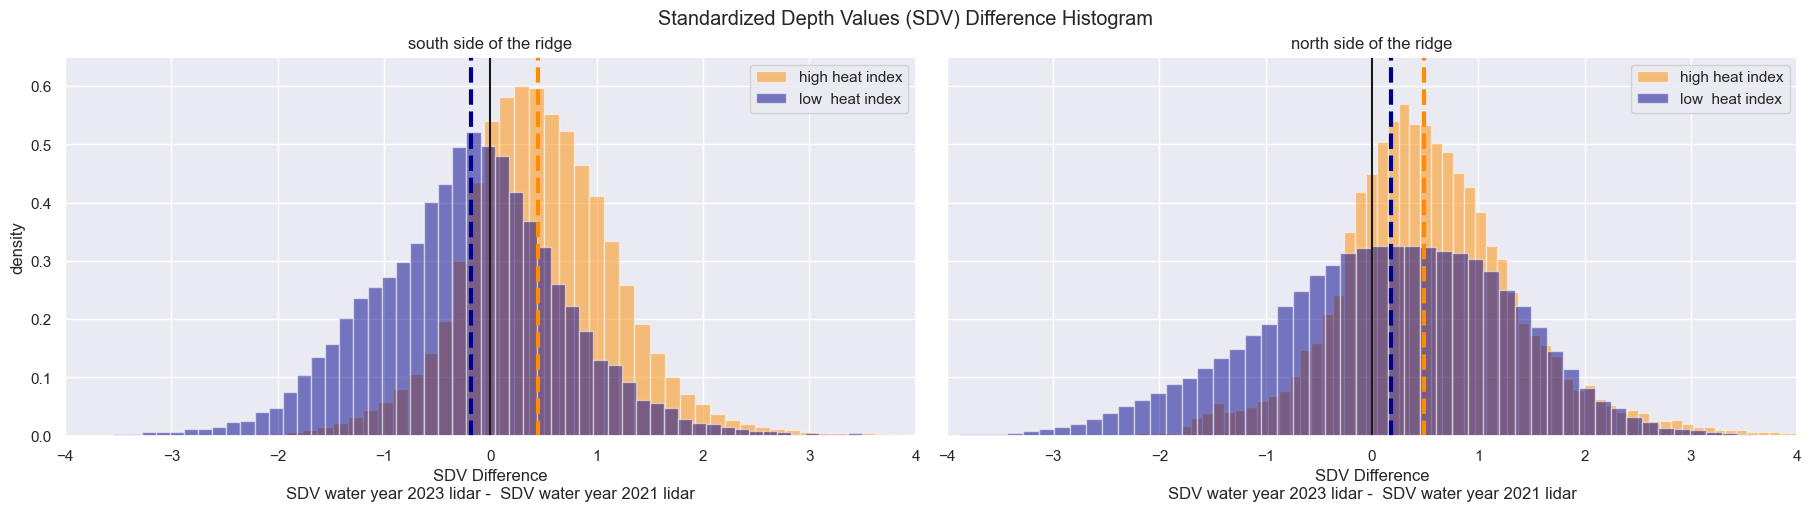

In [34]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,5), constrained_layout = True)
ds['diff_sdv_rapid_ncalm_new_norm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] ==  1)).plot.hist(ax=axes[0], bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm_new_norm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] == -1)).plot.hist(ax=axes[0], bins=100, color=colornorth, alpha=0.5, density=True, label='low  heat index');
ds['diff_sdv_rapid_ncalm_new_norm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] ==  1)).plot.hist(ax=axes[1], bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm_new_norm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] == -1)).plot.hist(ax=axes[1], bins=100, color=colornorth, alpha=0.5, density=True, label='low  heat index');

# plot the median line 
axes[0].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] ==  1)).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] == -1)).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] ==  1)).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] == -1)).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend()
axes[1].legend()

axes[0].set_ylim(0,0.65);
axes[0].set_xlim(-4,4);
axes[0].set_ylabel('density')
axes[0].set_xlabel('SDV Difference\nSDV water year 2023 lidar -  SDV water year 2021 lidar')
axes[1].set_xlabel('SDV Difference\nSDV water year 2023 lidar -  SDV water year 2021 lidar')

plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')
axes[0].set_title('south side of the ridge')
axes[1].set_title('north side of the ridge')

plt.show()

## SWE Calculations 
Now, adding the SWE analysis back in that we previously did 

In [30]:
#ds['hs_rapid_zeros_removed'] # snow depth 2023
#ds['hs_ncalm_zeros_removed'] # snow depth 2021

#ds['hs_rapid_zeros_removed'].where( np.isnan(ds.baf)).mean(dim=['x','y']) #this is snow depth in the control areas 
#ds['hs_rapid_zeros_removed'].where(~np.isnan(ds.baf)).mean(dim=['x','y']) #this is snow depth in the treatment areas 

#ds['hs_ncalm_zeros_removed'].where( np.isnan(ds.baf)).mean(dim=['x','y']) #this is snow depth in the control areas 
#ds['hs_ncalm_zeros_removed'].where(~np.isnan(ds.baf)).mean(dim=['x','y']) #this is snow depth in the treatment areas 

In [31]:
ds['hs_rapid_zeros_removed_control'] = ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)) #this is snow depth in the control areas 
ds['hs_rapid_zeros_removed_treatment'] = ds['hs_rapid_zeros_removed'].where(~np.isnan(ds.baf)) #this is snow depth in the treatment areas 

ds['hs_ncalm_zeros_removed_control'] = ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)) #this is snow depth in the control areas 
ds['hs_ncalm_zeros_removed_treatment'] = ds['hs_ncalm_zeros_removed'].where(~np.isnan(ds.baf)) #this is snow depth in the treatment areas 

In [32]:
ds['hs_rapid_control_s'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] ==  1)
ds['hs_rapid_control_n'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] == -1)

ds['hs_rapid_treatment_s'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] ==  1)
ds['hs_rapid_treatment_n'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] == -1)

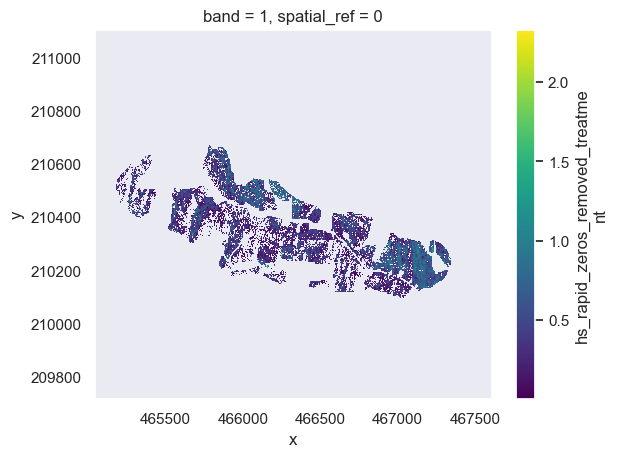

In [33]:
ds['hs_rapid_zeros_removed_treatment'].plot()

In [34]:
# colors 
colorcontrolsouth = 'tan'
colorcontrolnorth = 'lightsteelblue'
colortreatmentsouth = 'darkorange'
colortreatmentnorth = 'darkblue'

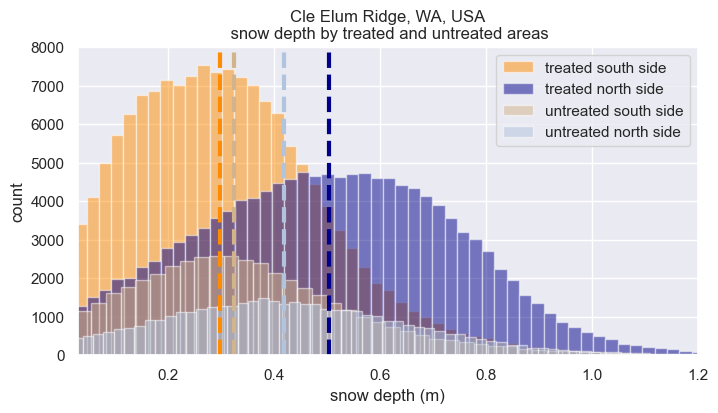

In [35]:
# plot histograms of the four groups 
fig, axes = plt.subplots(1, 1, figsize=(8,4))

ds['hs_rapid_treatment_s'].plot.hist(bins=100, label='treated south side', alpha=.5, color=colortreatmentsouth)
ds['hs_rapid_treatment_n'].plot.hist(bins=100, label='treated north side', alpha=.5, color=colortreatmentnorth)

ds['hs_rapid_control_s'].plot.hist(bins=100, label='untreated south side', alpha=.5, color=colorcontrolsouth)
ds['hs_rapid_control_n'].plot.hist(bins=100, label='untreated north side', alpha=.5, color=colorcontrolnorth)


# plot the median lines for the histograms\
width=3
plt.axvline(ds['hs_rapid_control_n'].median(), color=colorcontrolnorth, linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_rapid_control_s'].median(), color=colorcontrolsouth, linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_rapid_treatment_s'].median(), color=colortreatmentsouth, linestyle='dashed', linewidth=width)
plt.axvline(ds['hs_rapid_treatment_n'].median(), color=colortreatmentnorth, linestyle='dashed', linewidth=width)

# # legend order
# handles, labels = plt.gca().get_legend_handles_labels()
# order=[3,2,0,1]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.legend()

# constants
plt.title('Cle Elum Ridge, WA, USA\n snow depth by treated and untreated areas')
plt.xlabel('snow depth (m)')
plt.ylabel('count')

plt.xlim(0.03,1.2)
plt.ylim(0,8000)
plt.show()

Calculation for total snow depth in each of these groups, 

In [36]:
#lidar
ds['hs_control_n_sum'] = ds['hs_rapid_control_n'].sum(dim=['x','y'])
ds['hs_control_s_sum'] = ds['hs_rapid_control_s'].sum(dim=['x','y'])
ds['hs_treatment_n_sum']   = ds['hs_rapid_treatment_n'].sum(dim=['x','y'])
ds['hs_treatment_s_sum']   = ds['hs_rapid_treatment_s'].sum(dim=['x','y'])

# now, print all the totals 
print('treatment south: ', ds['hs_treatment_s_sum'].values)
print('treatment north: ', ds['hs_treatment_n_sum'].values)
print('untreated south: ', ds['hs_control_s_sum'].values)
print('untreated north', ds['hs_control_n_sum'].values)

treatment south:  [48176.83]
treatment north:  [68211.92]
untreated south:  [15852.717]
untreated north [18295.348]


In [37]:
total_hs = pd.DataFrame({'treated south': ds['hs_treatment_s_sum'].values,
                         'untreated south': ds['hs_control_s_sum'].values,
                             'treated north': ds['hs_treatment_n_sum'].values,
                             'untreated north': ds['hs_control_s_sum'].values})
total_hs.head()

,treated south,untreated south,treated north,untreated north
0,48176.828125,15852.716797,68211.921875,15852.716797


Text(0.5, 0, 'total snow depth (m)')

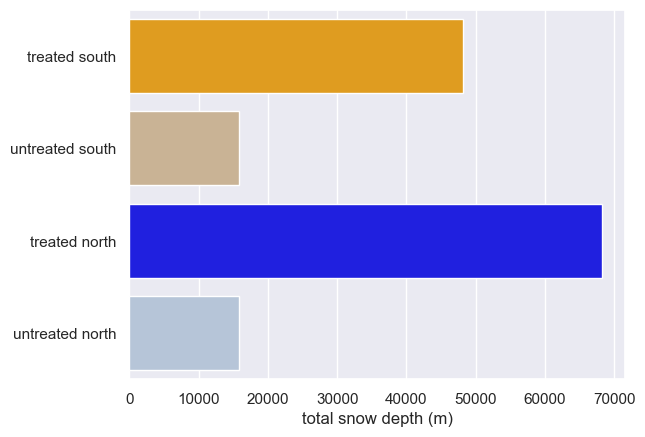

In [38]:
# make a color pallett 
mypal = ['orange', 'tan', 'blue', 'lightsteelblue']
sns.barplot(total_hs, orient='h', palette=mypal)
plt.xlabel('total snow depth (m)')

## Now, calculating the total SWE for the area, 
* since we have 1 m res rasters, we have each count in the hist = 1 m^2 
* Thus, we can take the total SWE (below) and givide it by the total count for that variable to normalize between the group sizes 

In [39]:
# make bar charts of the totals
# put the totals into a dataframe
density = 310 

total_swe = pd.DataFrame({'treated on the south side': (ds['hs_treatment_s_sum'].values*density)/(ds['hs_rapid_treatment_s'].count().values),
                        'untreated on the south side'  : (ds['hs_control_s_sum'].values*density)/(ds['hs_rapid_control_s'].count().values),
                        'treated on the north side': (ds['hs_treatment_n_sum'].values*density)/(ds['hs_rapid_treatment_n'].count().values),
                        'untreated on the north side'  : (ds['hs_control_n_sum'].values*density)/(ds['hs_rapid_control_n'].count().values),})

total_swe.head()

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,98.714527,109.677994,156.501469,135.391693


### Now, we are going to do this calculation with two different snow density measurements
1. with 310 kg/m3 (or 0.31% water) for everywhere
2. with 0.29 on the north and 0.34 on the south to see how the dense snow on the south side makes a difference in SWE totals 

In [40]:
densitynorth  =290
densitysouth = 340

total_swe_2 = pd.DataFrame({'treated on the south side': (ds['hs_treatment_s_sum'].values*densitysouth)/(ds['hs_rapid_treatment_s'].count().values),
                        'untreated on the south side'  : (ds['hs_control_s_sum'].values*densitysouth)/(ds['hs_rapid_control_s'].count().values),
                        'treated on the north side': (ds['hs_treatment_n_sum'].values*densitynorth)/(ds['hs_rapid_treatment_n'].count().values),
                        'untreated on the north side'  : (ds['hs_control_n_sum'].values*densitynorth)/(ds['hs_rapid_control_n'].count().values),})

total_swe_2.head()

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,108.267547,120.292,146.404603,126.656746


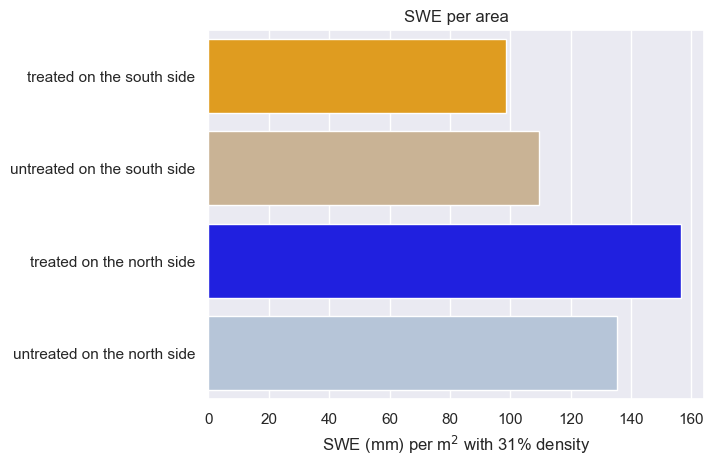

In [41]:
sns.barplot(total_swe, orient='h', palette=mypal)
plt.xlabel('SWE (mm) per m$^2$ with 31% density')
# plt.xlim(0,140)
plt.title('SWE per area')
plt.show()

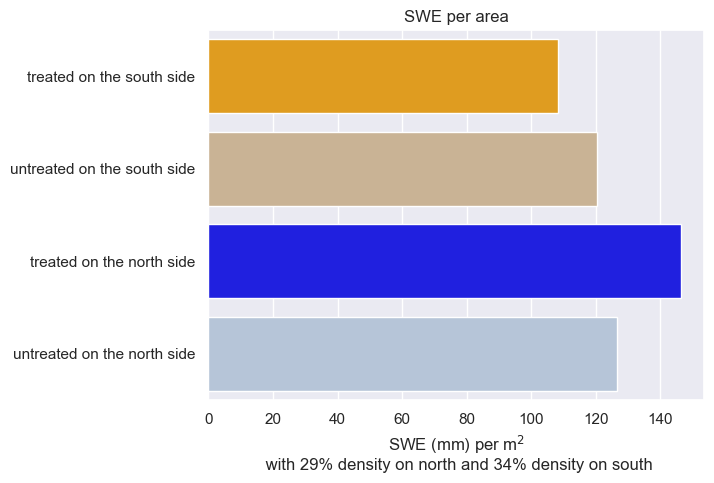

In [42]:
sns.barplot(total_swe_2, orient='h', palette=mypal)
plt.xlabel('SWE (mm) per m$^2$\n with 29% density on north and 34% density on south')
# plt.xlim(0,140)
plt.title('SWE per area')
plt.show()

### We also want some figures with total area

In [43]:
# put the totals into a dataframe
total_area = pd.DataFrame({'treated on the south side': ds['hs_rapid_treatment_s'].count().values,
                             'untreated on the south side': ds['hs_rapid_control_s'].count().values,
                             'treated on the north side': ds['hs_rapid_treatment_n'].count().values,
                             'untreated on the north side': ds['hs_rapid_control_n'].count().values,}, index=[0])

total_area # in m2


,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,151293,44807,135115,41890


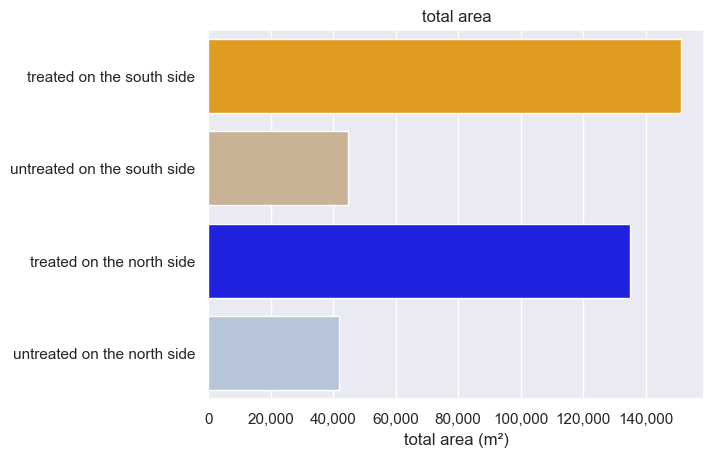

In [44]:
# make a color pallette
sns.barplot((total_area), orient='h', palette=mypal)
plt.xlabel('total area (m²)')

# format the x ticks to show the full number 
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
# add a comma between the thousands place and the hundreds place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ',')))
# plt.xlim(0,330)
# plt.xlim(0,2850000)
plt.title('total area')
plt.show()

In [45]:
total_area_km = total_area/1000000
total_area_km.head()

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,0.151293,0.044807,0.135115,0.04189


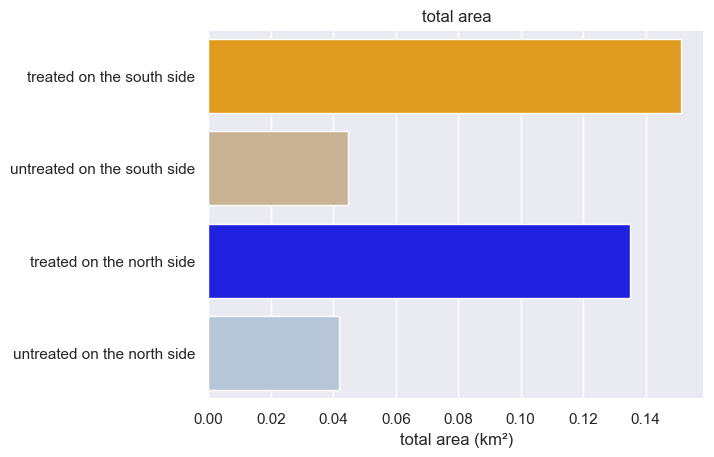

In [46]:
sns.barplot(total_area_km, orient='h', palette=mypal)
plt.xlabel('total area (km²)')
# plt.xlim(0,0.32)
plt.title('total area')
plt.show()

## Let's make a figure where we put all of these plots together 

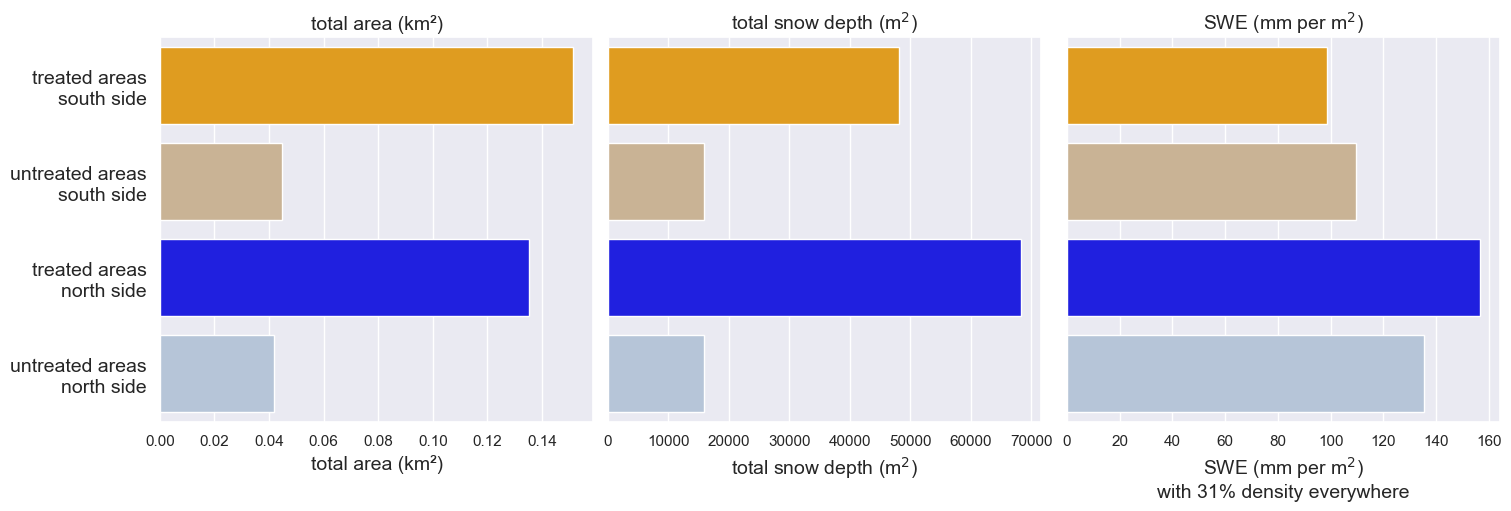

In [47]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(1, 3, sharex = False, sharey = True, figsize=(15,5), constrained_layout = True)

# plot the data on the axes
sns.barplot(total_area_km, orient='h', palette=mypal, ax=axes[0])
sns.barplot(total_hs, orient='h', palette=mypal, ax=axes[1])
sns.barplot(total_swe, orient='h', palette=mypal, ax=axes[2])

axes[0].set_title('total area (km²)', fontsize=14)
axes[1].set_title('total snow depth (m$^2$)', fontsize=14)
axes[2].set_title('SWE (mm per m$^2$)', fontsize=14)

axes[0].set_xlabel('total area (km²)', fontsize=14)
axes[1].set_xlabel('total snow depth (m$^2$)', fontsize=14)
axes[2].set_xlabel('SWE (mm per m$^2$)\nwith 31% density everywhere', fontsize=14)

axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)


plt.show()

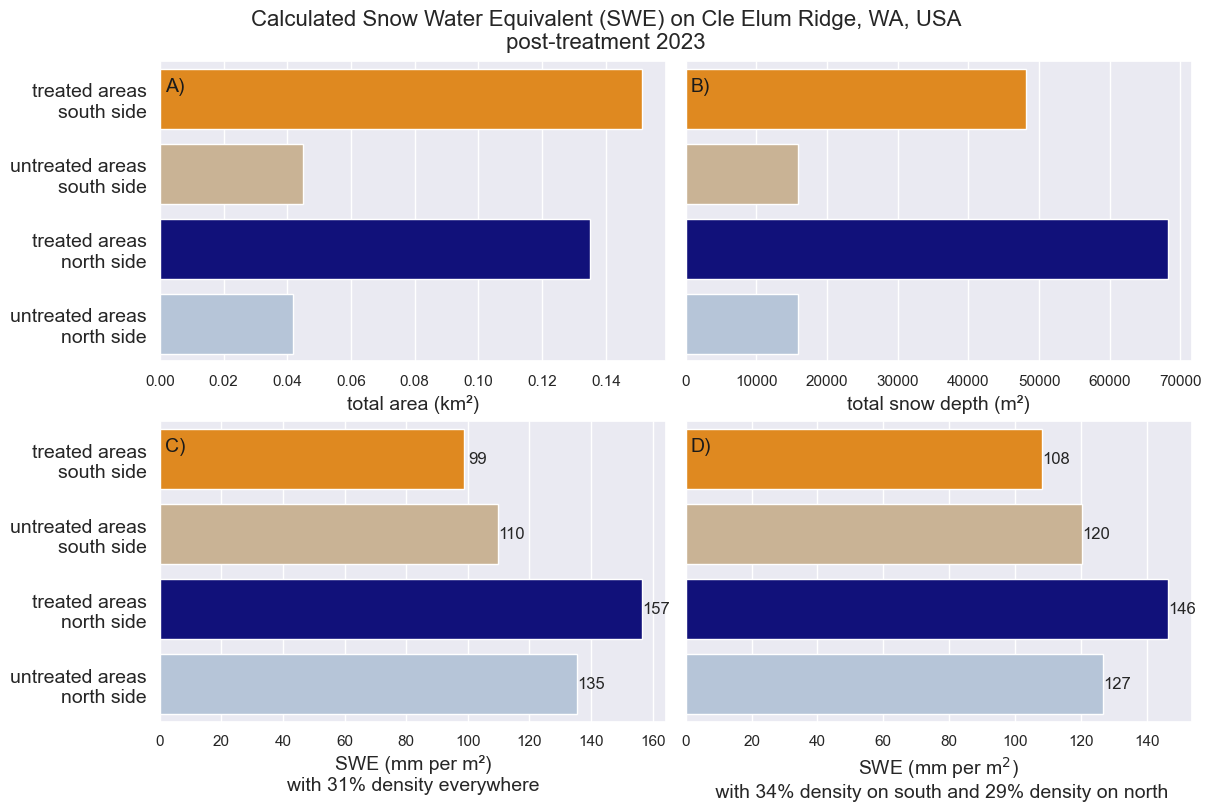

In [48]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(2, 2, sharex = False, sharey = True, figsize=(12,8), constrained_layout = True)

mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]

# plot the data on the axes
sns.barplot(total_area_km, orient='h', palette=mypal2, ax=axes[0,0])
# sns.barplot(total_area, orient='h', palette=mypal2, ax=axes[0,0])
sns.barplot(total_hs, orient='h', palette=mypal2, ax=axes[0,1])
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[1,0])
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[1,1])

# set titles 
# axes[0,0].set_title('total area (km²)', fontsize=16)
# # axes[0,0].set_title('total area (m²)', fontsize=16)
# axes[0,1].set_title('total snow depth (m²)', fontsize=16)
# axes[1,0].set_title('SWE (mm per m$^2$)', fontsize=16)
# axes[1,1].set_title('SWE (mm per m$^2$)', fontsize=16)

# set xlabels 
axes[0,0].set_xlabel('total area (km²)', fontsize=14)
# axes[0,0].set_xlabel('total area (m²)')
axes[0,1].set_xlabel('total snow depth (m²)', fontsize=14)
axes[1,0].set_xlabel('SWE (mm per m²)\nwith 31% density everywhere', fontsize=14)
axes[1,1].set_xlabel('SWE (mm per m$^2$)\n with 34% density on south and 29% density on north', fontsize=14)
   
# add the total number to the end of every barplot 
# for ax in axes.flatten(): # this for all the axes 
for ax in axes.flatten()[-2:]: # this to remove the first two axes
    for p in ax.patches:
        ax.annotate(format(p.get_width(), ',.0f'), 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha = 'center', va = 'center', 
                    # xytext = (20, 0), 
                    xytext = (10, 0), 
                    textcoords = 'offset points')
    
# change the y-tick mark names 
axes[0,0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
axes[1,0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)

plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)

# add A) B) C) D) to the subplots 
axes[0,0].text(0.01, 0.9, 'A)', fontsize=14, color='k', transform=axes[0,0].transAxes)
axes[0,1].text(0.01, 0.9, 'B)', fontsize=14, color='k', transform=axes[0,1].transAxes)
axes[1,0].text(0.01, 0.9, 'C)', fontsize=14, color='k', transform=axes[1,0].transAxes)
axes[1,1].text(0.01, 0.9, 'D)', fontsize=14, color='k', transform=axes[1,1].transAxes)

# save as a figure 
figure_name = 'SWE_calculations.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

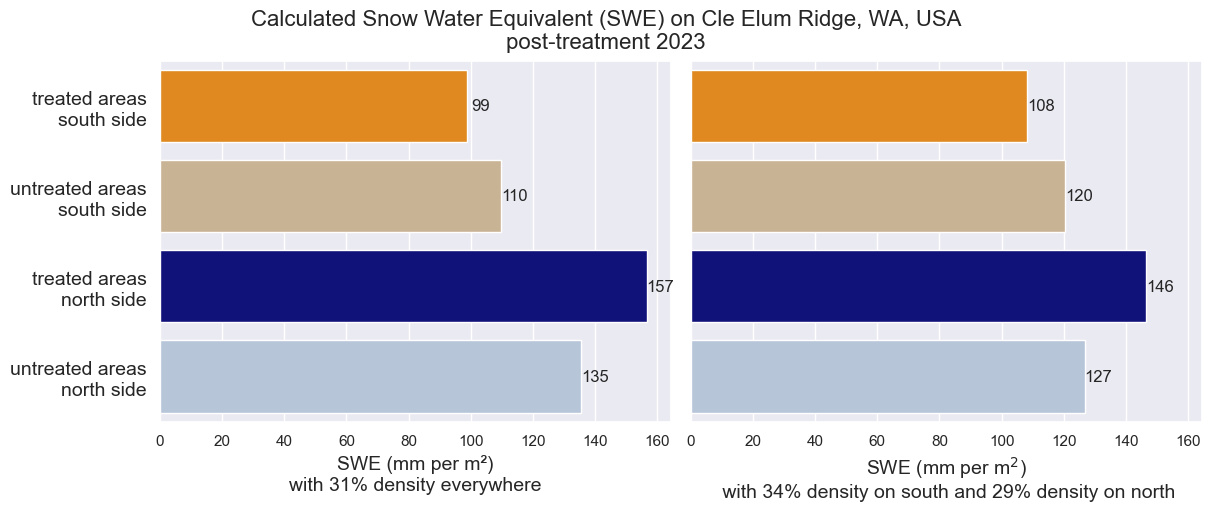

In [74]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(12,5), constrained_layout = True)

mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]

# plot the data on the axes
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[0])
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[1])

# set xlabels 
axes[0].set_xlabel('SWE (mm per m²)\nwith 31% density everywhere', fontsize=14)
axes[1].set_xlabel('SWE (mm per m$^2$)\n with 34% density on south and 29% density on north', fontsize=14)
   
# add the total number to the end of every barplot 
# for ax in axes.flatten(): # this for all the axes 
for ax in axes.flatten()[:]: # this to remove the first two axes
    for p in ax.patches:
        ax.annotate(format(p.get_width(), ',.0f'), 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha = 'center', va = 'center', 
                    # xytext = (20, 0), 
                    xytext = (10, 0), 
                    textcoords = 'offset points')
    
# change the y-tick mark names 
axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)

plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)

# add A) B) C) D) to the subplots 
# axes[0,0].text(0.01, 0.9, 'A)', fontsize=14, color='k', transform=axes[0,0].transAxes)
# axes[0,1].text(0.01, 0.9, 'B)', fontsize=14, color='k', transform=axes[0,1].transAxes)
# axes[1,0].text(0.01, 0.9, 'C)', fontsize=14, color='k', transform=axes[1,0].transAxes)
# axes[1,1].text(0.01, 0.9, 'D)', fontsize=14, color='k', transform=axes[1,1].transAxes)

# save as a figure 
# figure_name = 'SWE_calculations.png'
# plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

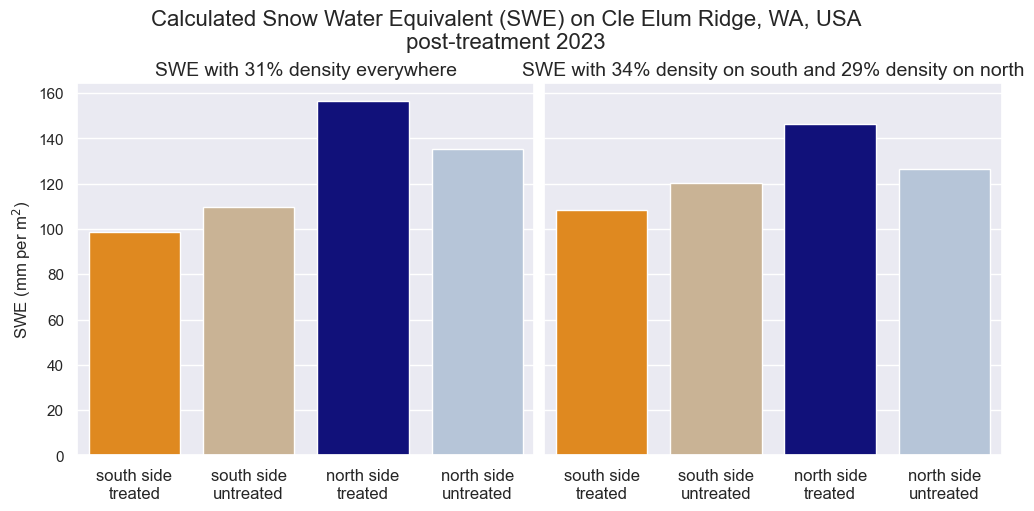

In [73]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(10,5), constrained_layout = True)

mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]

# plot the data on the axes
sns.barplot(total_swe, orient='v', palette=mypal2, ax=axes[0])
sns.barplot(total_swe_2, orient='v', palette=mypal2, ax=axes[1])

# set xlabels 
axes[0].set_title('SWE with 31% density everywhere', fontsize=14)
axes[1].set_title('SWE with 34% density on south and 29% density on north', fontsize=14)

axes[0].set_ylabel("SWE (mm per m$^2$)")
   
# add the total number to the end of every barplot 
# # for ax in axes.flatten(): # this for all the axes 
# for ax in axes.flatten()[:]: # this to remove the first two axes
#     for p in ax.patches:
#         ax.annotate(format(p.get_width(), ',.0f'), 
#                     (p.get_width(), p.get_y() + p.get_height() / 2), 
#                     ha = 'center', va = 'center', 
#                     # xytext = (20, 0), 
#                     xytext = (10, 0), 
#                     textcoords = 'offset points')
    
# change the y-tick mark names 
# axes[0].set_xticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 
#                          'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=12)
# axes[1].set_xticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 
#                          'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=12)

axes[0].set_xticklabels(['south side\ntreated', 'south side\nuntreated', 
                         'north side\ntreated', 'north side\nuntreated'], fontsize=12)
axes[1].set_xticklabels(['south side\ntreated', 'south side\nuntreated', 
                         'north side\ntreated', 'north side\nuntreated'], fontsize=12)

plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)

# add A) B) C) D) to the subplots 
# axes[0,0].text(0.01, 0.9, 'A)', fontsize=14, color='k', transform=axes[0,0].transAxes)
# axes[0,1].text(0.01, 0.9, 'B)', fontsize=14, color='k', transform=axes[0,1].transAxes)
# axes[1,0].text(0.01, 0.9, 'C)', fontsize=14, color='k', transform=axes[1,0].transAxes)
# axes[1,1].text(0.01, 0.9, 'D)', fontsize=14, color='k', transform=axes[1,1].transAxes)

# save as a figure 
# figure_name = 'SWE_calculations.png'
# plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

### Let's add in a bar chart for the total acre-ft for each domain, which is calculated in a speadsheet

In [55]:
swe_acreft_31 = pd.DataFrame({'treated south': 21.59,
                         'untreated south': 8.60,
                             'treated north': 20.90,
                             'untreated north': 7.15,}, index=[0])

swe_acreft_34_29 = pd.DataFrame({'treated south': 23.56,
                         'untreated south': 9.38,
                             'treated north': 19.43,
                             'untreated north': 6.73}, index=[0])
swe_acreft_31.head()
swe_acreft_34_29.head()

,treated south,untreated south,treated north,untreated north
0,23.56,9.38,19.43,6.73


But obviously, those numbers are calculated for the area (so the larger the area, the more water...)

So, let's add the calculation for "if the entire ridge was not-treated domain" and "if the entire ridge was treated domain"

In [66]:
ds['hs_rapid_control_s'].median().values

array(0.32409668)

In [76]:
# print('the median snow depth for the non-treated areas:', ds['hs_rapid_control'].median().values.round(3))

print('the median snow depth for the non-treated areas on the south side:', ds['hs_rapid_control_s'].median().values.round(3))
print('the median snow depth for the non-treated areas on the north side:', ds['hs_rapid_control_n'].median().values.round(3))
print('------------------------------------------------------------------------')
print('the median snow depth for the     treated areas on the south side:', ds['hs_rapid_treatment_s'].median().values.round(3))
print('the median snow depth for the     treated areas on the north side:', ds['hs_rapid_treatment_n'].median().values.round(3))

the median snow depth for the non-treated areas on the south side: 0.324
the median snow depth for the non-treated areas on the north side: 0.419
------------------------------------------------------------------------
the median snow depth for the     treated areas on the south side: 0.298
the median snow depth for the     treated areas on the north side: 0.504


Now, we need to plot all these regions together in a figure to show

In [79]:
# Create a binary variable versions of all these areas
ds['hs_rapid_control_s_binary'] = ds['hs_rapid_control_s'].where(~(ds['hs_rapid_control_s'] > 0), 1)
ds['hs_rapid_control_n_binary'] = ds['hs_rapid_control_n'].where(~(ds['hs_rapid_control_n'] > 0), 2)
ds['hs_rapid_treatment_s_binary'] = ds['hs_rapid_treatment_s'].where(~(ds['hs_rapid_treatment_s'] > 0), 3)
ds['hs_rapid_treatment_n_binary'] = ds['hs_rapid_treatment_n'].where(~(ds['hs_rapid_treatment_n'] > 0), 4)

ds['control_treatment_binary'] = ds['hs_rapid_control_s'].where(~(ds['hs_rapid_control_s'] > 0), 1)
ds['control_treatment_binary'] = ds['control_treatment_binary'].where(~(ds['hs_rapid_control_n'] > 0), 2)
ds['control_treatment_binary'] = ds['control_treatment_binary'].where(~(ds['hs_rapid_treatment_s'] > 0), 3)
ds['control_treatment_binary'] = ds['control_treatment_binary'].where(~(ds['hs_rapid_treatment_n'] > 0), 4)

I calcuated total SWE in acre-ft ("as if the treatments were never performed" across the ridge) in the spreadsheet... 

In [79]:
# Now, let's add the values to a dataframe to plot 
total_swe_acreft_speadsheet_31 = pd.DataFrame({
                                    # 'entire domain as if no forest treatments occured': 55.5,
                                    'south side as if no forest treatments occured': 29.8,
                                    'north side as if no forest treatments occured': 24.2,
                                    # 'entire domain with the forest treatments': 122.0, 
                                    'south side with the forest treatments': 30.2,
                                    'north side with the forest treatments': 28.0,
                                    }, index=[0])

total_swe_acreft_speadsheet_34_29 = pd.DataFrame({
                                    # 'entire domain as if no forest treatments occured': 55.9,
                                    'south side as if no forest treatments occured': 32.6,
                                    'north side as if no forest treatments occured': 22.6,
                                    # 'entire domain with the forest treatments': 121.6, 
                                    'south side with the forest treatments': 32.9,
                                    'north side with the forest treatments': 26.2,
                                    }, index=[0])

In [80]:
# Now, let's add the values to a dataframe to plot 
total_swe_acreft_speadsheet_31 = pd.DataFrame({
                                    'south side with the forest treatments': 30.2,
                                    'south side as if no forest treatments occured': 29.8,
                                    'north side with the forest treatments': 28.0,
                                    'north side as if no forest treatments occured': 24.2,
                                    }, index=[0])

total_swe_acreft_speadsheet_34_29 = pd.DataFrame({
                                    'south side with the forest treatments': 32.9,
                                    'south side as if no forest treatments occured': 32.6,
                                    'north side with the forest treatments': 26.2,
                                    'north side as if no forest treatments occured': 22.6,
                                    }, index=[0])

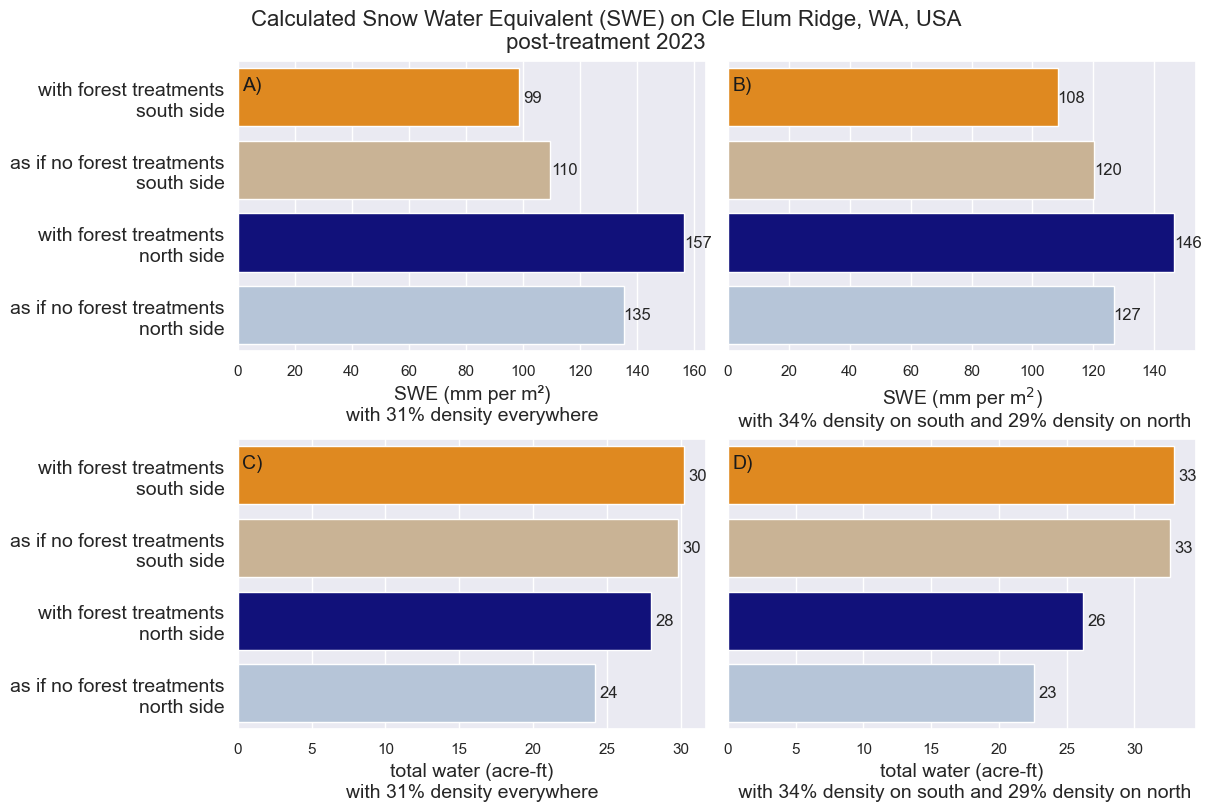

In [91]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(2, 2, sharex = False, sharey = True, figsize=(12,8), constrained_layout = True)

mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]

# plot the data on the axes

sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[0,0])
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[0,1])

sns.barplot(total_swe_acreft_speadsheet_31, orient='h', palette=mypal2, ax=axes[1,0])
sns.barplot(total_swe_acreft_speadsheet_34_29, orient='h', palette=mypal2, ax=axes[1,1])

# set titles 
# axes[0,0].set_title('total area (km²)', fontsize=16)
# # axes[0,0].set_title('total area (m²)', fontsize=16)
# axes[0,1].set_title('total snow depth (m²)', fontsize=16)
# axes[1,0].set_title('SWE (mm per m$^2$)', fontsize=16)
# axes[1,1].set_title('SWE (mm per m$^2$)', fontsize=16)

# set xlabels 
axes[0,0].set_xlabel('SWE (mm per m²)\nwith 31% density everywhere', fontsize=14)
axes[0,1].set_xlabel('SWE (mm per m$^2$)\n with 34% density on south and 29% density on north', fontsize=14)

axes[1,0].set_xlabel('total water (acre-ft)\nwith 31% density everywhere', fontsize=14)
# axes[0,0].set_xlabel('total area (m²)')
axes[1,1].set_xlabel('total water (acre-ft)\n with 34% density on south and 29% density on north', fontsize=14)
   
# add the total number to the end of every barplot 
for ax in axes.flatten(): # this for all the axes 
# for ax in axes.flatten()[-2:]: # this to remove the first two axes
    for p in ax.patches:
        ax.annotate(format(p.get_width(), ',.0f'), 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha = 'center', va = 'center', 
                    # xytext = (20, 0), 
                    xytext = (10, 0), 
                    textcoords = 'offset points')
    
# change the y-tick mark names 
axes[0,0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
axes[1,0].set_yticklabels(['with forest treatments\nsouth side', 'as if no forest treatments\nsouth side', 
                           'with forest treatments\nnorth side', 'as if no forest treatments\nnorth side'], fontsize=14)

plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)

# add A) B) C) D) to the subplots 
axes[0,0].text(0.01, 0.9, 'A)', fontsize=14, color='k', transform=axes[0,0].transAxes)
axes[0,1].text(0.01, 0.9, 'B)', fontsize=14, color='k', transform=axes[0,1].transAxes)
axes[1,0].text(0.01, 0.9, 'C)', fontsize=14, color='k', transform=axes[1,0].transAxes)
axes[1,1].text(0.01, 0.9, 'D)', fontsize=14, color='k', transform=axes[1,1].transAxes)

# save as a figure 
# figure_name = 'SWE_calculations.png'
# plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

But, acre-ft as total water is going to make the south side look like there were more treatmetns of course... (compared to the north)

So, it's try to conver instead the SWE in mm per m2, to ft per acre 

In [86]:
total_swe

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,98.714527,109.677994,156.501469,135.391693


In [85]:
total_swe_ft_per_acre = total_swe * 13.378 # (1 mm per m2 = 13.378 ft / acre)
total_swe_2_ft_per_acre = total_swe_2 * 13.378 # (1 mm per m2 = 13.378 ft / acre)
total_swe_ft_per_acre

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,1320.602948,1467.272217,2093.676654,1811.270142


but now these numbers seem huge and not realistic... so I'm conufsed. This is not the same as an acre-ft of water...

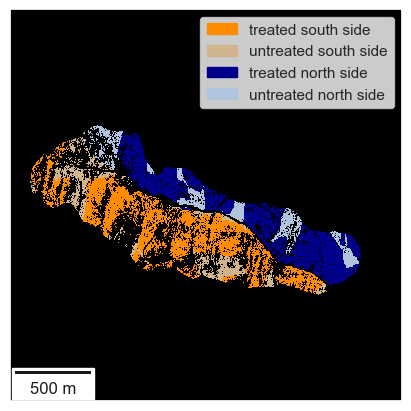

In [80]:
fig = plt.figure(figsize=(4,4), constrained_layout = True)
ax = fig.gca()

# plot 3
ds['control_treatment_binary'].plot(vmin=1, vmax=4, cmap=ListedColormap([colorcontrolsouth, colorcontrolnorth, colortreatmentsouth, colortreatmentnorth]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colortreatmentsouth: "treated south side", 
                    colorcontrolsouth: "untreated south side",
                 colortreatmentnorth: "treated north side",                 
                 colorcontrolnorth: "untreated north side",} 
                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

plt.title('')

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

# # export the figure with high resolution
# figure_name = 'untreatedandtreateddomainmap.png'
# plt.savefig(figure_path + figure_name, dpi=500)

plt.show()